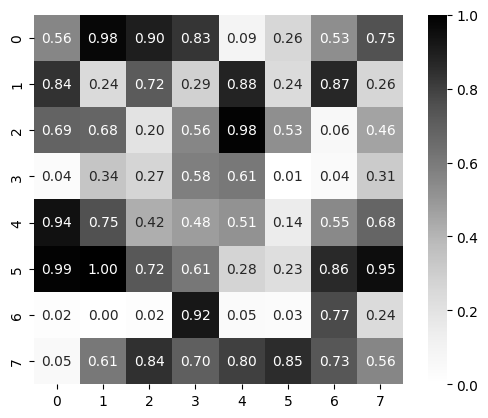

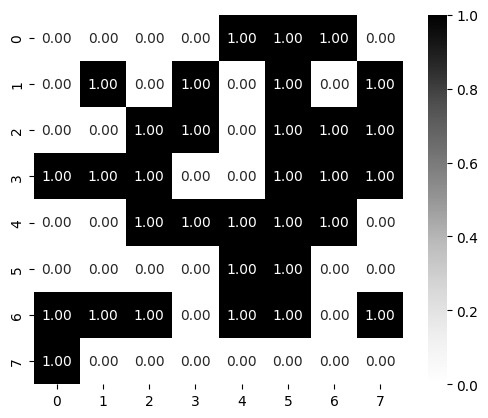

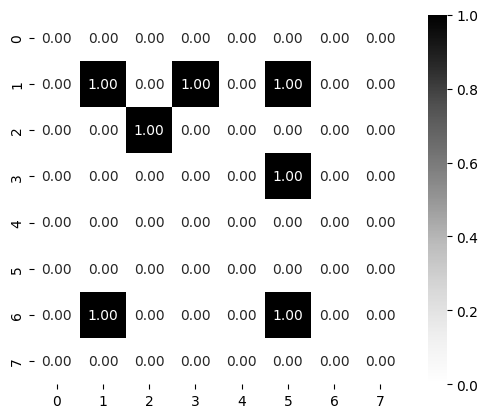

In [28]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

# random 8*8 array

arr = np.random.rand(8, 8)
arr -= np.min(arr)
arr /= np.max(arr)

sns.heatmap(
    arr, 
    cmap='Greys',       # 흑백
    annot=True,         # 셀 안에 값 표시
    fmt=".2f",          # 소수점 2자리
    cbar=True,          # 색상바 표시
    square=True         # 정사각형 셀
)
plt.show()


def get_masking_idx(arr, masking_ratio, locality_assumntion = False):
    num_elements = arr.size
    num_masking = int(num_elements * masking_ratio)
    threshold = sorted(arr.flatten(), reverse=True)[-num_masking]

    if locality_assumntion:
        masking_idx = []
        w, h = arr.shape
        for i in range(w):
            for j in range(h):
                if arr[i, j] <= threshold and arr[i, j] < arr[max(0, i-1), j] \
                                          and arr[i, j] < arr[min(w-1, i+1), j] \
                                          and arr[i, j] < arr[i, max(0, j-1)] \
                                          and arr[i, j] < arr[i, min(h-1, j+1)]:
                    masking_idx.append((i, j))
        return np.array(masking_idx)
    else:
        # 전체 배열에서 masking_ratio 비율만큼 인덱스 선택
        masking_idx = np.argwhere(arr <= threshold)
        return masking_idx

idx = get_masking_idx(arr, 0.5)
arr_masked = np.zeros_like(arr)
arr_masked[idx[:, 0], idx[:, 1]] = 1.0
sns.heatmap(
    arr_masked, 
    cmap='Greys',       # 흑백
    annot=True,         # 셀 안에 값 표시
    fmt=".2f",          # 소수점 2자리
    cbar=True,          # 색상바 표시
    square=True         # 정사각형 셀
)
plt.show()


idx = get_masking_idx(arr, 0.5, locality_assumntion=True)
arr_masked = np.zeros_like(arr)
arr_masked[idx[:, 0], idx[:, 1]] = 1.0
sns.heatmap(
    arr_masked, 
    cmap='Greys',       # 흑백
    annot=True,         # 셀 안에 값 표시
    fmt=".2f",          # 소수점 2자리
    cbar=True,          # 색상바 표시
    square=True         # 정사각형 셀
)
plt.show()


In [45]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

# random 8*8 array

# arr = np.random.rand(1, 8)
arr = np.array([[1,2,3,4,5,6,7,8]])
arr_left = np.concatenate([arr[:, 1:], arr[:, :1]], axis=1)
arr_right = np.concatenate([arr[:, -1:], arr[:, :-1]], axis=1)
not_local_min = (arr > arr_left) | (arr < arr_right)

print("arr: \n", arr)
print("arr_left: \n", arr_left)
print("arr_right: \n", arr_right)
print("not_local_min: \n", not_local_min)

arr: 
 [[1 2 3 4 5 6 7 8]]
arr_left: 
 [[2 3 4 5 6 7 8 1]]
arr_right: 
 [[8 1 2 3 4 5 6 7]]
not_local_min: 
 [[ True False False False False False False  True]]


In [87]:
import torch

def make_mask(batch=8, time=124, threshold=0.5, device=None, dtype=torch.float32):
    """
    랜덤 텐서 X(배치x타임)과 조건(연속 False 금지)을 만족하며
    가능한 많이 masking(False)한 mask(배치x타임, bool)을 반환.
      - True  : keep (값≥threshold 또는 규칙상 살려둠)
      - False : mask (값<threshold 중에서 연속되지 않게 최대 선택)
    """
    X = torch.rand(batch, time, device=device, dtype=dtype)
    low = X < threshold                         # 후보(False로 만들 위치)
    t = torch.arange(time, device=X.device).expand(batch, -1)

    # 직전의 "keep(=True)" 시점 인덱스 (없으면 -1) — 구간별 인덱스 리셋을 벡터화로 구현
    last_keep_idx, _ = torch.cummax(torch.where(~low, t, torch.full_like(t, -1)), dim=1)

    # 각 낮은 값 구간(run) 내 위치의 짝/홀로 번갈아 선택 → 최대 개수면서 인접 False 없음
    dist_since_keep = t - last_keep_idx - 1
    choose_false = low & (dist_since_keep.remainder(2) == 0)

    mask = ~choose_false                        # 최종 mask (bool)
    return X, mask

# 간단한 검증 예시
for _ in range(10):
    X, mask = make_mask(threshold=0.95)
    for d in mask:
        for i in range(len(d) -1):
            if not(d[i] or d[i+1]):
                print("연속된 False 발견:", d[i:i+2])



In [88]:
mask

tensor([[False,  True,  True, False,  True, False,  True, False,  True, False,
          True, False,  True, False,  True,  True, False,  True, False,  True,
         False,  True, False,  True, False,  True, False,  True, False,  True,
         False,  True, False,  True, False,  True, False,  True, False,  True,
         False,  True, False,  True, False,  True, False,  True, False,  True,
         False,  True, False,  True,  True, False,  True,  True, False,  True,
         False,  True, False,  True, False,  True, False,  True, False,  True,
         False,  True, False,  True, False,  True, False,  True, False,  True,
         False,  True, False,  True, False,  True, False,  True, False,  True,
         False,  True, False,  True, False,  True,  True, False,  True, False,
          True, False,  True, False,  True, False,  True, False,  True, False,
          True, False,  True, False,  True, False,  True, False,  True, False,
          True, False,  True, False],
        [False

In [75]:
import torch

data = torch.zeros((4,5,6))
data = torch.mean(data, dim=1)  # (4, 6) -> 각 배치에 대해 5차원 평균

data.shape

torch.Size([4, 6])

In [60]:



# 반복 호출 시:

H, W = 8, 8
cand = precompute_cand(H, W, parity=0)   # i+j 홀수칸 후보 목록 (1회)
A = np.random.randn(H, W)
mask = mask_low_on_cand(A, cand, ratio=0.22, ratio_basis="all")


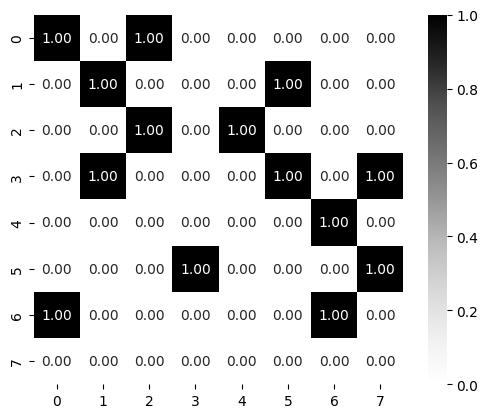

In [62]:
sns.heatmap(
    mask, 
    cmap='Grays',       # 흑백
    annot=True,         # 셀 안에 값 표시
    fmt=".2f",          # 소수점 2자리
    cbar=True,          # 색상바 표시
    square=True         # 정사각형 셀
)
plt.show()
